In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
# done to calculate information gain
from scipy.stats import zscore
# done to calculate z-score
from ipywidgets import interact, widgets
import plotly.express as px

In [3]:
df = pd.read_excel('Career data_PDA_4053.xlsx')

In [4]:
print(df.isna().sum().sum())

89


## C L E A N - U P

> describe raw data and/or generate a schema for understanding the raw data

In [5]:
# a reusable function for generating a schema in order to understand the data better
def generateSchema(df):
    schema = pd.DataFrame({
        'column_name': df.columns,
        'dType': [df[col].dtype for col in df.columns], # using list comprehension
        'missing_values': [df[col].isna().sum() for col in df.columns]
    })

    modeOrMeanList = []
    # getting top 3 occuring values if dtype is object else getting a range
    for col in df.columns:
        if df[col].dtype == object:
            modes = df[col].value_counts().head(3).index.tolist()
            modeOrMeanList.append(modes)
            # print(col, '----', modes)
        elif df[col].dtype == float:
            mean = round(df[col].mean(), 2)
            # print(col, '---', mean)
            modeOrMeanList.append(mean)
        else:
            modeOrMeanList.append('')
    schema['modesOrMeans'] = modeOrMeanList
    schema.loc[len(schema)] = ['Total Records', len(df), '', '']

    # print(schema)
    return schema

schema = generateSchema(df)
# print(type(schema))
schema.to_csv('rawDataSchema.csv', index=False)


In [6]:
print(df.info())
print('\n------------------------------\n')
print(df.describe())
print('\n------------------------------\n')
print(df.shape)
print('\n------------------------------\n')
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Field of Study               4999 non-null   object 
 1   Current Occupation           4996 non-null   object 
 2   Age                          4996 non-null   float64
 3   Gender                       4993 non-null   object 
 4   Years of Experience          4998 non-null   float64
 5   Education Level              4994 non-null   object 
 6   Industry Growth Rate         4995 non-null   object 
 7   Job Satisfaction             4998 non-null   float64
 8   Work-Life Balance            4997 non-null   float64
 9   Job Opportunities            4993 non-null   float64
 10  Salary                       4994 non-null   object 
 11  Job Security                 4996 non-null   float64
 12  Career Change Interest       4995 non-null   object 
 13  Skills Gap        

> filling or removing missing values; converting necessary features to numeric; and encoding the categorical data to numeric values

In [7]:
def cleaner(df):
  # converting string values present in applicable columns to numeric (float64) - so the whole column is numeric, as they should be
  df['Salary'] = pd.to_numeric(df['Salary'], errors = 'coerce')
  df['Career Change Interest'] = pd.to_numeric(df['Career Change Interest'], errors = 'coerce')
  df['Certifications'] = pd.to_numeric(df['Certifications'], errors = 'coerce')
  df['Geographic Mobility'] = pd.to_numeric(df['Geographic Mobility'], errors = 'coerce')

  # dropping the rows with null values
  df.dropna(how = 'any', inplace = True) # dropping a record if ANY cell is NaN


  # encoding columns that have strings into numeric values, to keep the doors open for application of ML models

    # we use if conditions because .map() turns anything that doesn't match the provided values to NaN (which happens after
    # rerunning this cell, because they have already been mapped to new values), essentially leading ALL RECORDS to be have
    # at least one NaN value when rerunning this cell and hence being dropped

  if df['Gender'].dtype == 'O':
    # gender {male: 0, female: 1}
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

  if df['Industry Growth Rate'].dtype == 'O':
    # industry growth rate {high: 1, medium: 0, low: -1}
    df['Industry Growth Rate'] = df['Industry Growth Rate'].map({'High': 1, 'Medium': 0, 'Low': -1})

  if df['Education Level'].dtype == 'O':
    # education level {high school: 1, bachelor's: 2, master's: 3, phd: 4}
    df['Education Level'] = df['Education Level'].map({'High School': 1, "Bachelor's": 2, "Master's": 3, 'PhD': 4})

  # resetting the index, as pandas doesn't update the indexes after dropping rows
  df = df.reset_index(drop = True)
  return df

df = cleaner(df)

# counting total number of missing values
nullCounter = 0
for i in df.isna().sum():
  nullCounter += i
print(nullCounter) # output after normalization but before dropping NaNs: 94 (1.88% of the total data - dropping these is okay)
print(len(df))


0
4940


## A N A L Y S I S

> generate a schema for understanding the processed data

In [8]:
cleanDataSchema = generateSchema(df)
schema.to_csv('cleanDataSchema.csv', index=False)

> getting correlation of each column with 'Likely to Change Occupation' column from a correlation matrix

In [9]:
corr_matrix = df.corr(numeric_only = True)
corr_matrix.loc['Likely to Change Occupation']
corr_matrix.loc['Likely to Change Occupation'].sort_values()

,Likely to Change Occupation
Job Satisfaction,-0.597744
Job Security,-0.030327
Skills Gap,-0.025748
Certifications,-0.020820
Work-Life Balance,-0.019548
Career Change Events,-0.015837
Gender,-0.013421
Salary,-0.010370
Education Level,-0.009351
Industry Growth Rate,-0.008929


> calculating z-score of each numeric column to find outliers
[ z score shows how far a data point is from the mean of the dataset ]

In [10]:
# creating a new dataframe to store all z-scores of all numeric columns in the original dataframe
zScore_df = pd.DataFrame()
for i in df.columns:
  if df[i].dtype != 'O':
    zScore_df[f'Z_Score - {i}'] = zscore(df[i])

outlierCounter = {}
for i in zScore_df.columns:
  outliers = zScore_df[abs(zScore_df[i]) > 3]
  # as per empirical rule, we know that data-points with z-score more that 3 are categorized as outliers
  outlierCounter[i] =  len(outliers)

# print(outlierCounter)
# outliers = pd.DataFrame(outliers)
# for i in outliers.keys()

> calculating information gain of each column

Field of Study  -->  0.0010045600153822942
Current Occupation  -->  0.0009528736739943949
Age  -->  0.0023219648591187997
Gender  -->  9.006214060874873e-05
Years of Experience  -->  0.0038211907911621726
Education Level  -->  0.000127155345468144
Industry Growth Rate  -->  0.0007015563311189577
Job Satisfaction  -->  0.31720003952025744
Work-Life Balance  -->  0.001122730990940457
Job Opportunities  -->  0.011263247403403086
Salary  -->  0.6762328541999096
Job Security  -->  0.0016800162776455518
Career Change Interest  -->  0.12959426240170296
Skills Gap  -->  0.0006361385632430577
Certifications  -->  0.00021639548789026408
Freelancing Experience  -->  1.9156820496052385e-05
Geographic Mobility  -->  4.174635748005473e-05
Professional Networks  -->  0.0011858831098761347
Career Change Events  -->  0.00018919411366202787
Technology Adoption  -->  0.0015806946583843823
{'Field of Study': np.float64(0.0010045600153822942), 'Current Occupation': np.float64(0.0009528736739943949), 'Age':

<Axes: >

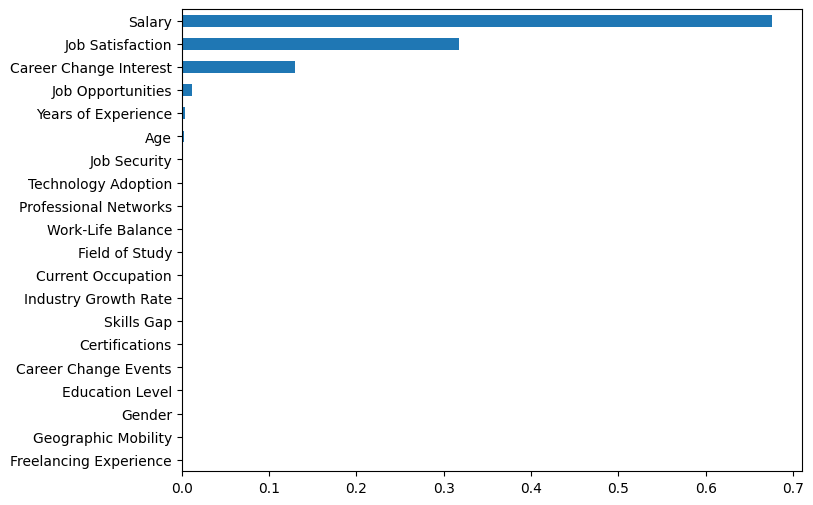

In [11]:
IG_Map = {}
for i in df.columns:
  if df[i].dtype != 0 and i != 'Likely to Change Occupation':
    IG_Map[i] = mutual_info_score(df[i], df['Likely to Change Occupation'])
    print(i, ' --> ', mutual_info_score(df[i], df['Likely to Change Occupation']))
plt.figure(figsize=(8,6))
print(IG_Map)
ig_df = pd.Series(IG_Map)
ig_df.head()
ig_df.sort_values().plot(kind = 'barh')


grouped mean analysis

In [19]:
results = []
for col in df.columns:
  means = df.groupby(col)['Likely to Change Occupation'].mean().sort_values()
  print('\n----------------------------------------\n')


In [20]:
for col in df.columns:
  if (df[col].dtype != object):
    print(f'Subject Column: {col}\n',df.groupby('Likely to Change Occupation')[col].mean().sort_values())
    print('\n----------------------------------------\n')

Subject Column: Age
 Likely to Change Occupation
0.0    39.343868
1.0    39.391844
Name: Age, dtype: float64

----------------------------------------

Subject Column: Gender
 Likely to Change Occupation
1.0    0.502482
0.0    0.516038
Name: Gender, dtype: float64

----------------------------------------

Subject Column: Years of Experience
 Likely to Change Occupation
0.0    19.706604
1.0    19.818440
Name: Years of Experience, dtype: float64

----------------------------------------

Subject Column: Education Level
 Likely to Change Occupation
1.0    2.486879
0.0    2.508019
Name: Education Level, dtype: float64

----------------------------------------

Subject Column: Industry Growth Rate
 Likely to Change Occupation
1.0    0.003191
0.0    0.017925
Name: Industry Growth Rate, dtype: float64

----------------------------------------

Subject Column: Job Satisfaction
 Likely to Change Occupation
1.0    4.002128
0.0    7.495755
Name: Job Satisfaction, dtype: float64

----------------

## Menu Driven Visualizer

In [ ]:
from IPython.display import display, clear_output
# in progress

binominalC = ['Gender', 'Career Change Interest', 'Career Change Events', 'Freelancing Experience', 'Geographic Mobility', 'Certifications', ]
discreteC = ['Age', 'Years of Experience', 'Job Satisafaction', 'Work Life Balance', 'Job Opportunity', 'Salary', 'Job Security', 'Skills Gap']
ordinalC = ['Education Level', 'Industry Growth Level']
classifiedC = ['Field of Study', 'Current Occupation']
targetC = 'Likelihood to Change Occupation'
binominalChartOptions = ['Count Plot', 'Pie Chart']
ordinalChartOptions = ['Box Plot', 'Bar Plot']
discreteChartOptions = ['Box Plot', 'Scatter Plot', 'Histogram']
classifiedChartOptions = ['Bar Chart']

column_dropdown = widgets.Dropdown(
    options=binominalC + discreteC + ordinalC + classifiedC,
    description='Feature:',
    value='Gender'
)

chart_dropdown = widgets.Dropdown(
    options=binominalChartOptions,
    description='Chart Type:'
)

output = widgets.Output()

def update_chart_options(change):
    col = change['new']
    if col in binominalC:
        chart_dropdown.options = binominalChartOptions
    elif col in discreteC:
        chart_dropdown.options = discreteChartOptions
    elif col in ordinalC:
        chart_dropdown.options = ordinalChartOptions
    elif col in classifiedC:
        chart_dropdown.options = classifiedChartOptions

column_dropdown.observe(update_chart_options, names='value')

def plot_graph(change=None):
    with output:
        clear_output(wait=True)
        col = column_dropdown.value
        chart_type = chart_dropdown.value

        # BINOMINAL
        if col in binominalC:
            if chart_type == 'Count Plot':
                fig = px.bar(df, x=col, color=targetC, barmode='group', title=f'{targetC} by {col}')
            elif chart_type == 'Pie Chart':
                fig = px.pie(df, names=col, title=f'{col} Distribution')

        # DISCRETE
        elif col in discreteC:
            if chart_type == 'Box Plot':
                fig = px.box(df, x=targetC, y=col, points='all', title=f'{col} vs {targetC}')
            elif chart_type == 'Histogram':
                fig = px.histogram(df, x=col, color=targetC, barmode='overlay', nbins=20,
                                   title=f'{col} Distribution by {targetC}')
            elif chart_type == 'Scatter Plot':
                fig = px.scatter(df, x=col, y=targetC, color=targetC, title=f'{col} vs {targetC}')

        # ORDINAL
        elif col in ordinalC:
            if chart_type == 'Box Plot':
                fig = px.box(df, x=col, y=targetC, points='all', title=f'{targetC} vs {col}')
            elif chart_type == 'Bar Plot':
                mean_data = df.groupby(col)[targetC].mean().reset_index()
                fig = px.bar(mean_data, x=col, y=targetC, title=f'Average {targetC} by {col}')

        # CLASSIFIED
        elif col in classifiedC:
            if chart_type == 'Bar Chart':
                mean_data = df.groupby(col)[targetC].mean().reset_index()
                fig = px.bar(mean_data, x=col, y=targetC, title=f'Average {targetC} by {col}')
                fig.update_xaxes(categoryorder='total descending')

        fig.show()


plot_button = widgets.Button(description='Show Graph', button_style='success')
plot_button.on_click(plot_graph)

ui = widgets.VBox([column_dropdown, chart_dropdown, plot_button, output])
display(ui)

# def plotBinominamColumns(feature, chart_type):
#     plt.figure(figsize = (7, 5))
#     plt.title(f"{feature} vs Likely to Change Occupation")
#     plt.xlabel('Likely to Change Occupation')
#     plt.ylabel(feature)
#     plt.tight_layout()
#     plt.show()

# # Dropdowns for column and chart type
# feature_dropdown = widgets.Dropdown(
#     options = binominalC,
#     description = 'Feature:',
#     style = {'description_width': 'initial'},
# )

# chart_dropdown = widgets.Dropdown(
#     options = ['Scatter', 'Boxplot', 'Histogram', 'Bar Chart', 'Count Plot'],
#     description = 'Chart Type:',
#     style = {'description_width': 'initial'},
# )
# interact(plot_feature, feature = feature_dropdown, chart_type = chart_dropdown)



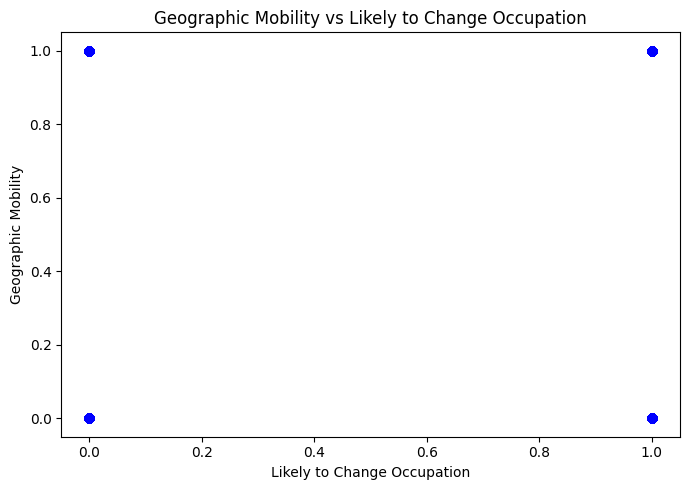

In [21]:
# Function to plot chosen feature and graph type
def plot_feature(feature, chart_type):
    plt.figure(figsize = (7, 5))
    plt.title(f"{feature} vs Likely to Change Occupation")
    plt.xlabel('Likely to Change Occupation')
    plt.ylabel(feature)

    # Scatter plot
    if chart_type == 'Scatter':
        plt.scatter(df['Likely to Change Occupation'], df[feature], alpha = 0.6, c = 'blue')

    # Box plot
    elif chart_type == 'Boxplot':
        sns.boxplot(x = feature, y = 'Likely to Change Occupation', data = df)

    # Histogram
    elif chart_type == 'Histogram':
        plt.hist(df[feature], bins = 50, alpha = 0.7, color = 'green', orientation = 'horizontal')

    # Count Plot
    elif chart_type == 'Count Plot':
      sns.countplot(x = 'Likely to Change Occupation', hue = feature, data = df)

    # Bar chart (for categorical or few unique values)
    elif chart_type == 'Bar Chart':
        grouped = df.groupby(feature)['Likely to Change Occupation'].mean()
        grouped.plot(kind = 'bar', color = 'tab:purple')
        plt.ylabel(f"Average 'Likely to Change Occupation'")

    plt.tight_layout()
    plt.show()

# Dropdowns for column and chart type
feature_dropdown = widgets.Dropdown(
    options = [col for col in df.columns if col != 'Likely to Change Occupation'],
    description = 'Feature:',
    style = {'description_width': 'initial'},
)

chart_dropdown = widgets.Dropdown(
    options = ['Scatter', 'Boxplot', 'Histogram', 'Bar Chart', 'Count Plot'],
    description = 'Chart Type:',
    style = {'description_width': 'initial'},
)

# Combine both widgets interactively
interact(plot_feature, feature = feature_dropdown, chart_type = chart_dropdown)
